In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import numpy as np
import math as m
import scipy as ss
from scipy import stats

In [3]:
task1 = pd.read_csv('5_task_1.csv')
task2 = pd.read_csv('5_task_2.csv')

In [4]:
task1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [5]:
task2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4

In [12]:
#Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена

In [13]:
ss.stats.levene(task1.query('group == "A"').events,
                task1.query('group == "B"').events,
                task1.query('group == "C"').events,
                center='mean')

LeveneResult(statistic=2.22744039161356, pvalue=0.10782184379785464)

In [15]:
#  нулевая гипотеза не отклоняется (р > 0.05) и дисперсии примерно одинаковы

Проверим, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность делаем семплирование (1000 наблюдений)

In [ ]:
# Семплирование необходимо для проверки, так как на больших выборках могут получаться неверные результаты. 
# параметр random_state=17 в методе sample

In [16]:
a_gr = task1.query('group == "A"').events.sample(1000, random_state=17)
b_gr = task1.query('group == "B"').events.sample(1000, random_state=17)
c_gr = task1.query('group == "C"').events.sample(1000, random_state=17)

In [17]:
stats.shapiro(a_gr)

(0.9973153471946716, 0.09609563648700714)

In [19]:
stats.shapiro(b_gr)

(0.9980798363685608, 0.31768906116485596)

In [18]:
stats.shapiro(c_gr)

(0.9981185793876648, 0.3359004259109497)

In [ ]:
# все распределения нормальные, т.к. р > 0.05

Проводим тест

Для сравнения средних используем однофакторный дисперсионный анализ (f_oneway)

р-уровень значимости составил 0
 

In [20]:
stats.f_oneway(task1.query('group == "A"').events,
                task1.query('group == "B"').events,
                task1.query('group == "C"').events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [ ]:
#p = 0, значит статистически значимые различия между группами есть

Теперь используем критерий Тьюки и смотрим, между какими группами есть статистически значимые различия

In [22]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
MultiComparison)

print(pairwise_tukeyhsd(task1.events, task1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


In [23]:
# Как видно по последней колонке, все нулевые гипотезы были отклонены,
# поэтому мы делаем вывод, что средние всех трёх групп значимо различаются.

### Видим, что В (16:9) приносит наибольшее число покупок
Также замечаем, что в критерии Тьюки при попарном сравнении среднее группы В больше, чем у группы А (на 8.034) и у группы С (на 10.1433)

Построим график, чтобы на картинке посмотреть, какой формат будет приносить больше покупок

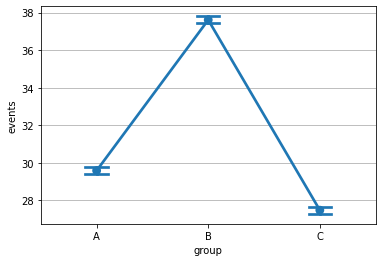

In [24]:
plt.grid(True)
sns.pointplot(x='group', y='events', data=task1, capsize=.2)

### Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [27]:
test_group = task2.query('group == "test"').events
control_group = task2.query('group == "control"').events

In [ ]:
#Посмотрим на среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [34]:
task2.query('group == "test"').groupby('segment').events.describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
high,10000.0,69.938500,8.403974,40.0,64.0,70.0,76.0,102.0
low,40000.0,33.025925,5.720845,13.0,29.0,33.0,37.0,59.0


In [35]:
task2.query('group == "control"').groupby('segment').events.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
high,10000.0,59.97,7.81,31.0,55.0,60.0,65.0,89.0
low,40000.0,20.03,4.47,4.0,17.0,20.0,23.0,41.0


Проведем тест, а затем используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

In [40]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [41]:
formula = 'events ~ segment + group + segment:group'
model = ols(formula, task2).fit()
aov_table = anova_lm(model, typ=2)

In [42]:
round(aov_table,2)
# Как видно по последней колонке, значим как эффект обоих факторов, так
# и их взаимодействие (нулевая гипотеза отклоняется)

,sum_sq,df,F,PR(>F)
segment,23624796.65,1.0,689756.38,0.0
group,3837195.41,1.0,112031.86,0.0
segment:group,36642.44,1.0,1069.82,0.0
Residual,3424955.89,99996.0,NaN,NaN


In [43]:
# создадим колонку с комбинацией сегмента и группы для упрощения дальнейшего анализа
task2['combination'] = task2['group'] + ' / ' + task2['segment']
task2

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high
...,...,...,...,...,...
99995,60695,control,low,15.0,control / low
99996,5934,control,low,16.0,control / low
99997,30046,control,low,22.0,control / low
99998,26474,control,low,21.0,control / low


In [44]:
MultiComp = MultiComparison(task2.events, task2.combination)
print(MultiComp.tukeyhsd().summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


In [ ]:
#Визуализируем результаты теста

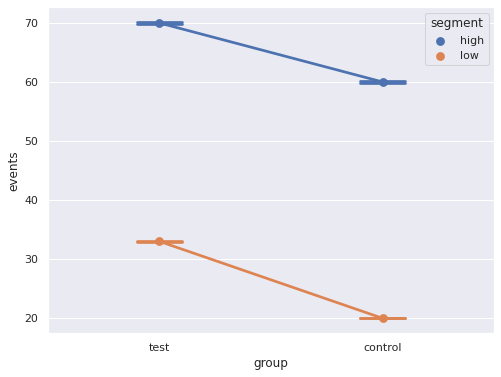

In [52]:
plt.figure(figsize=(8,6))
plt.grid(True)
sns.pointplot(x='group', y='events', hue='segment', data=task2, capsize=.2)

### Выводы:

Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой (сравнивались control/high и test / high, control/low и test/low)

В том числе, судя по графику, для всех групп среднее значение events увеличилось, поэтому решение: выкатываем новую версию